In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append("..") # Adds higher directory to python modules path.
from helper_functions_paper import *

In [2]:
def rename(df):
    df['modelname_old'] = df['modelname']
    df['modelname'] = df['modelname'].replace('least_squares', 'K-means: Least squares  (sign-flip)')
    df['modelname'] = df['modelname'].replace('diametrical', 'K-means: Diametrical')
    df['modelname'] = df['modelname'].replace('complex_diametrical', 'K-means: Complex diametrical')
    df['modelname'] = df['modelname'].replace('grassmann', 'K-means: Grassmann')
    df['modelname'] = df['modelname'].replace('weighted_grassmann', 'K-means: Weighted Grassmann')
    df['modelname'] = df['modelname'].replace('Watson', 'Mixture: Watson')
    df['modelname'] = df['modelname'].replace('Complex_Watson', 'Mixture: Complex Watson')
    df['modelname'] = df['modelname'].replace('ACG', 'Mixture: ACG')
    df['modelname'] = df['modelname'].replace('Complex_ACG', 'Mixture: Complex ACG')
    df['modelname'] = df['modelname'].replace('MACG', 'Mixture: MACG')
    df['modelname'] = df['modelname'].replace('SingularWishart', 'Mixture: Singular Wishart')
    df['modelname'] = df['modelname'].replace('Normal', 'Mixture: Gaussian')
    df['modelname'] = df['modelname'].replace('Complex_Normal', 'Mixture: Complex Gaussian')
    df['Set'] = df['Set'].replace('train', 'Train')
    df['Set'] = df['Set'].replace('test1', 'Within-subject test')
    df['Set'] = df['Set'].replace('test2', 'Out-of-sample test')
    # if column LR doesnt exist, make it with zeros
    if 'LR' not in df.columns:
        df['LR'] = 0
    if 'HMM' not in df.columns:
        df['HMM'] = False

    names = [] #without the Kmeans or Mixture or HMM
    names2 = [] #with
    for i in range(len(df)):
        if 'Watson' in df['modelname'].iloc[i]:
            add_rank = ''
        else:
            add_rank = ' rank='+str(df['rank'].iloc[i])
        if df['HMM'].iloc[i]:
            add_HMM = 'HMM: '
        else:
            add_HMM = ''
        if 'Mixture' in df['modelname'].iloc[i]:
            names.append(df['modelname'].iloc[i][8:]+add_rank)
            if df['HMM'].iloc[i]:
                names2.append(add_HMM + df['modelname'].iloc[i][8:]+add_rank)
            else:
                names2.append(add_HMM + df['modelname'].iloc[i]+add_rank)
        else:
            names.append(df['modelname'].iloc[i][:8])
            names2.append(df['modelname'].iloc[i])
            
    df['names'] = names
    df['names2'] = names2
    df['Accuracy'] = df['classification_accuracy']
    return df

In [3]:
#model order loglik data
df2_all_tasks = pd.DataFrame()
modelnames = ['Complex_Watson','Normal','MACG','SingularWishart','Watson','ACG','least_squares','diametrical','complex_diametrical','grassmann','weighted_grassmann','Complex_ACG','Complex_Normal']
for modelname in modelnames:
    for rank in [1,5,10,25,50,100]:
        if modelname in ['Complex_Watson','Watson','least_squares','diametrical','complex_diametrical','grassmann','weighted_grassmann'] and rank != 25:
            continue
        try:
            df = pd.read_csv('../data/results/116_results/all_tasksmodelorder_realdata_'+modelname+'_K=7_rank='+str(rank)+'.csv')
        except:
            print('File not found for model:', modelname, 'rank:', rank)
            continue
        df = df[df['rank'] == rank]
        df2_all_tasks = pd.concat([df2_all_tasks,df])
df2_all_tasks = rename(df2_all_tasks)

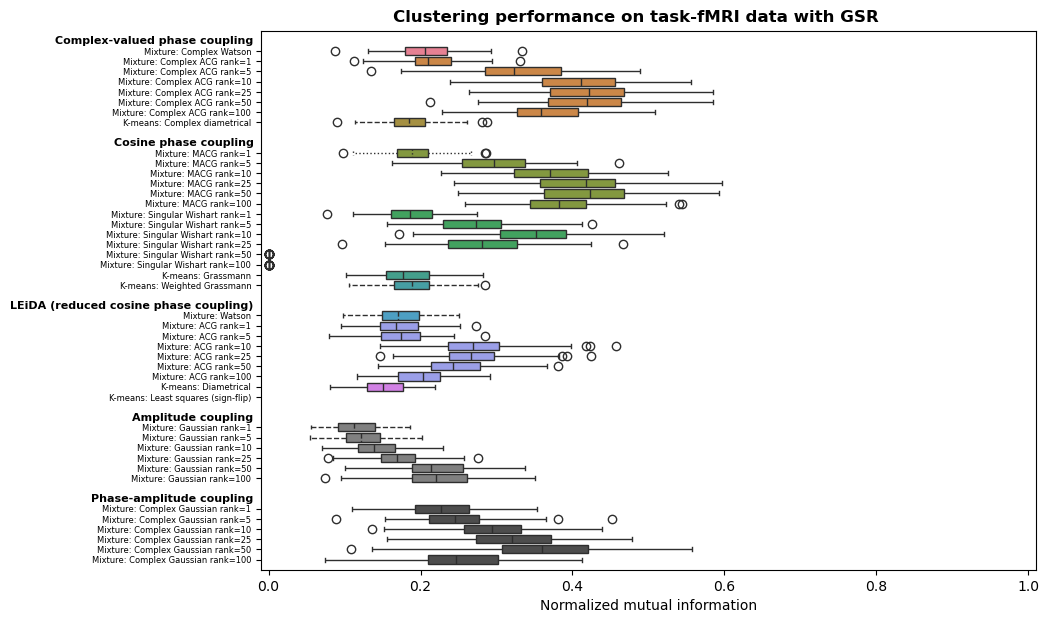

In [ ]:
ranks = [1,5,10,25,50,100]
df_fig = df2_all_tasks[df2_all_tasks['Set']=='Out-of-sample test']
df_fig = df_fig[df_fig['inner']==0]
fig = horizontal_boxplot(df_fig,type=1,ranks=ranks)
fig.suptitle('Clustering performance on task-fMRI data with GSR',fontsize=12, fontweight='bold', y=0.91)
fig.savefig('figures/alltasks.pdf', bbox_inches='tight')

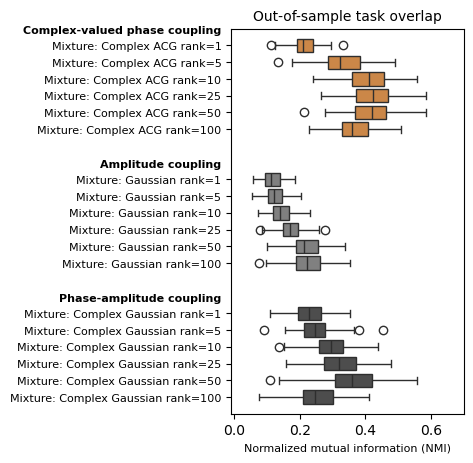

In [ ]:
ranks = [1,5,10,25,50,100]
order = [*['Mixture: Complex ACG rank='+str(rank) for rank in ranks],
    'space1','space2',
    *['Mixture: Gaussian rank='+str(rank) for rank in ranks],'space7','space8',
    *['Mixture: Complex Gaussian rank='+str(rank) for rank in ranks]]
palette_husl = sns.color_palette("husl", n_colors=11, desat=1)
palette_husl.append((0.5,0.5,0.5))
palette_husl.append((0.3,0.3,0.3))
palette_husl2 = [palette_husl[1]]*len(ranks)+[palette_husl[-1]]*2+[palette_husl[11]]*len(ranks)+[palette_husl[-1]]*2+[palette_husl[12]]*len(ranks)
# df_fig = df[df['Set']=='Out-of-sample test']
for i in range(1,9):
    df_fig2 = pd.concat([df_fig,pd.DataFrame({'NMI':[np.nan],'names2':['space'+str(i)]}, index=[0])], ignore_index=True)
fig = plt.figure(figsize=(3,5))

sns.boxplot(x='NMI', y='names2', data=df_fig2, palette=palette_husl2, order=order)
plt.xlabel('Normalized mutual information (NMI)',fontsize=8)
plt.xlim([-0.01,1.01])
plt.ylabel('')

# add extra text next to y-ticks that aren't there
ticks_per_group = np.array([len(ranks), len(ranks), len(ranks)])
additional_ticks = np.concatenate([[0],np.cumsum(ticks_per_group+2)])
ticks_list = [np.arange(ticks_per_group[i]) + additional_ticks[i] for i in range(len(ticks_per_group))]
ticks_list = np.concatenate(ticks_list)

xtitlepos = -0.04
ytitlepos = [-0.7,7.3,15.3]
plt.yticks(ticks_list, fontsize=8)
    
plt.text(xtitlepos, ytitlepos[0], 'Complex-valued phase coupling', fontsize=8,fontweight='bold', ha='right')
plt.text(xtitlepos, ytitlepos[1], 'Amplitude coupling', fontsize=8,fontweight='bold', ha='right')
plt.text(xtitlepos, ytitlepos[2], 'Phase-amplitude coupling', fontsize=8,fontweight='bold', ha='right')

# change the line styles
styles = ['-']*len(ranks)+['-']*len(ranks)+['-']*len(ranks)
#repeat every element of styles six times
styles2 = [item for item in styles for i in range(5)]
l = 0
for i,artist in enumerate(plt.gca().get_children()):
    if isinstance(artist, plt.Line2D):
        #if linestyle is not none
        if artist.get_linestyle() != 'None':
            artist.set_linestyle(styles2[l])
            l+=1

plt.ylim([22,-1])
plt.xlim([-0.01,0.7])
plt.title('Out-of-sample task overlap', fontsize=10)
plt.savefig('figures/alltasks_nmi_3models.pdf', bbox_inches='tight')

In [ ]:
from matplotlib.patches import Rectangle
def plot_posterior(all_avg_test_posterior,NMIs, ranks, modelname, highlight_rank=25):
    num_ranks = len(ranks)
    fig, axs = plt.subplots(num_ranks + 1, 1, figsize=(7, 1.5 * num_ranks + 1), 
                            gridspec_kw={'height_ratios': [1]*num_ranks + [0.15],'hspace':0.1}, 
                            sharex=True)

    labels = ['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']
    widths = [176,253,316,284,232,274,405]  # must sum to 1940
    colors1 = sns.light_palette("seagreen",7)  # use seaborn color palette
    # Cumulative widths to find positions
    starts = np.cumsum([0] + widths[:-1])
    ends = np.cumsum(widths)
    space_between_tasks = 50

    for i, rank in enumerate(ranks):
        # make a title but set it to the right of the plot
        if rank==highlight_rank:
            #make it boldface
            axs[i].text(0.997, .97, modelname+r' rank-' + str(rank) + ', NMI=' + r'$\mathbf{' + '{0:.2f}'.format(NMIs[i]) + '}$', fontsize=8, ha='right', transform=axs[i].transAxes, va='top')
        else:
            axs[i].text(0.995, .97, modelname+r' rank-' + str(rank) + ', NMI=' + '{0:.2f}'.format(NMIs[i]), fontsize=8, ha='right', transform=axs[i].transAxes,va='top')
        axs[i].set_ylim(-0.05, 1.15)
        axs[i].set_xticks([])
        axs[i].set_yticks([0, 0.5, 1])
        axs[i].set_yticklabels(['0', '0.5', '1'], fontsize=8)
        axs[i].grid(True, linestyle='--', alpha=0.5)
        axs[i].set_ylabel('Avg. posterior', fontsize=8)
        # axs[i].plot(all_avg_test_posterior[i].T)
        data = all_avg_test_posterior[i]
        #add a space between tasks
        data2 = np.zeros((data.shape[0],data.shape[1] + space_between_tasks * 6))
        for j in range(len(starts)):
            data2[:, starts[j]+j*space_between_tasks:ends[j]+j*space_between_tasks] = data[:, starts[j]:ends[j]]
        data2[data2==0] = np.nan  # Set zeros to NaN for better visualization
        axs[i].plot(data2.T, linewidth=1.5, alpha=0.8)

    # Create the colored label boxes in the bottom subplot
    label_ax = axs[-1]
    label_ax.axis('off')  # Hide the axes

    for i, (start, width, label, color) in enumerate(zip(starts, widths, labels, colors1)):
        rect = Rectangle((start + i*space_between_tasks, 0), width, 1, transform=label_ax.transData,
                        color=color, ec='black', alpha=0.8)
        label_ax.add_patch(rect)
        label_ax.text(start + i*space_between_tasks + width / 2, 0.5, label, ha='center', va='center', fontsize=6, color='black')

    # Set x-limits
    axs[-1].set_xlim(-30, np.sum(widths)+6*space_between_tasks +30)
    return fig,axs

Rank: 1
Rank: 5
Rank: 10
Rank: 25
Rank: 50
Rank: 100


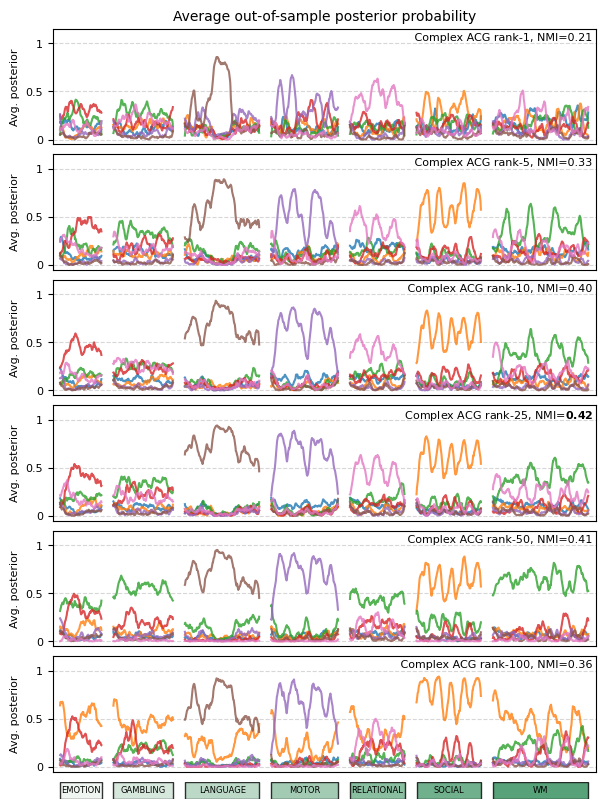

In [ ]:
# plot posteriors
modelname = 'Complex_ACG'
modelname2 = 'Mixture: Complex ACG'
inner = 0
ranks = [1,5,10,25,50,100]
tasks = ['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']
num_points = np.array([176,253,316,284,232,274,405])
K = len(tasks)
all_avg_test_posterior = []
for rank in ranks:
    print('Rank:', rank)
    posterior = np.genfromtxt('../data/results/116_results/posteriors/all_tasksmodelorder_realdata_'+modelname+'_K=7_rank='+str(rank)+'_inner'+str(inner)+'.txt', delimiter=',')
    avg_test_posterior = np.zeros((K,np.sum(num_points)))
    for sub in range(99):
        avg_test_posterior += 1/99*posterior[:,sub*np.sum(num_points):(sub+1)*np.sum(num_points)]
    all_avg_test_posterior.append(avg_test_posterior)
NMIs = []
for r in ranks:
    NMIs.append(df2_all_tasks[(df2_all_tasks['modelname'] == modelname2) & (df2_all_tasks['inner'] == inner) & (df2_all_tasks['Set'] == 'Out-of-sample test')& (df2_all_tasks['rank'] == r)]['NMI'].values.mean())

fig,axs = plot_posterior(all_avg_test_posterior, NMIs, ranks, modelname2[8:])
axs[0].set_title('Average out-of-sample posterior probability', fontsize=10)
fig.savefig('figures/complex_ACG_posteriors_all_tasks.pdf', bbox_inches='tight')

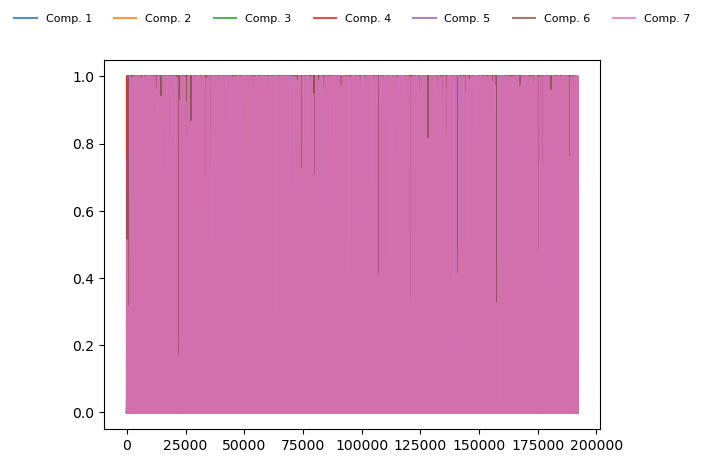

In [ ]:
#make the legend of the previous figure here
fig = plt.figure()
plt.plot(posterior.T, linewidth=1.5, alpha=0.8)
plt.legend(['Comp. '+str(i+1) for i in range(7)], fontsize=8, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=7, frameon=False)
fig.savefig('figures/complex_ACG_posteriors_all_tasks_legend.pdf', bbox_inches='tight')

Rank: 1
Rank: 5
Rank: 10
Rank: 25
Rank: 50
Rank: 100


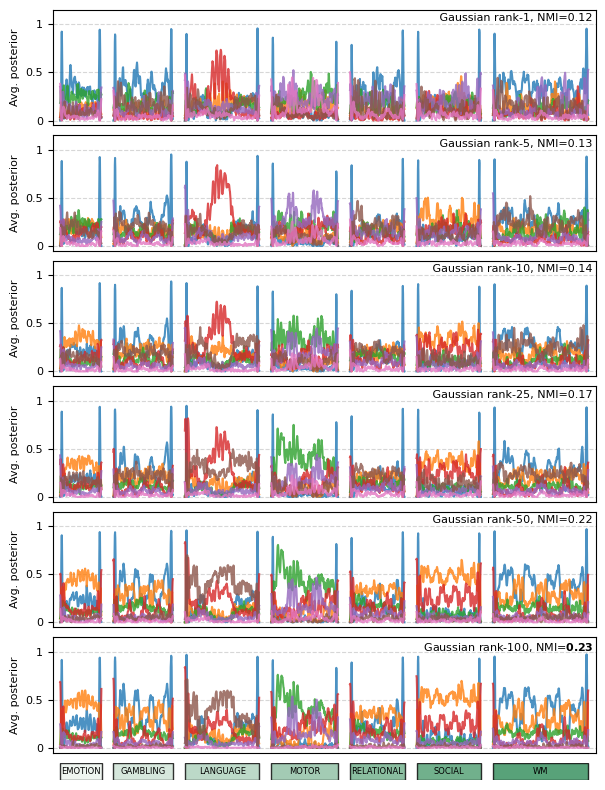

In [ ]:
# plot posteriors
modelname = 'Normal'
modelname2 = 'Mixture: Gaussian'
inner = 0
ranks = [1,5,10,25,50,100]
tasks = ['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']
num_points = np.array([176,253,316,284,232,274,405])
K = len(tasks)
all_avg_test_posterior = []
for rank in ranks:
    print('Rank:', rank)
    posterior = np.genfromtxt('../data/results/116_results/posteriors/all_tasksmodelorder_realdata_'+modelname+'_K=7_rank='+str(rank)+'_inner'+str(inner)+'.txt', delimiter=',')
    avg_test_posterior = np.zeros((K,np.sum(num_points)))
    for sub in range(99):
        avg_test_posterior += 1/99*posterior[:,sub*np.sum(num_points):(sub+1)*np.sum(num_points)]
    all_avg_test_posterior.append(avg_test_posterior)
NMIs = []
for r in ranks:
    NMIs.append(df2_all_tasks[(df2_all_tasks['modelname'] == modelname2) & (df2_all_tasks['inner'] == inner) & (df2_all_tasks['Set'] == 'Out-of-sample test')& (df2_all_tasks['rank'] == r)]['NMI'].values.mean())

fig,axs = plot_posterior(all_avg_test_posterior, NMIs, ranks, modelname2[8:], highlight_rank=100)
fig.savefig('figures/normal_posteriors_all_tasks.pdf', bbox_inches='tight')

Rank: 1
Rank: 5
Rank: 10
Rank: 25
Rank: 50
Rank: 100


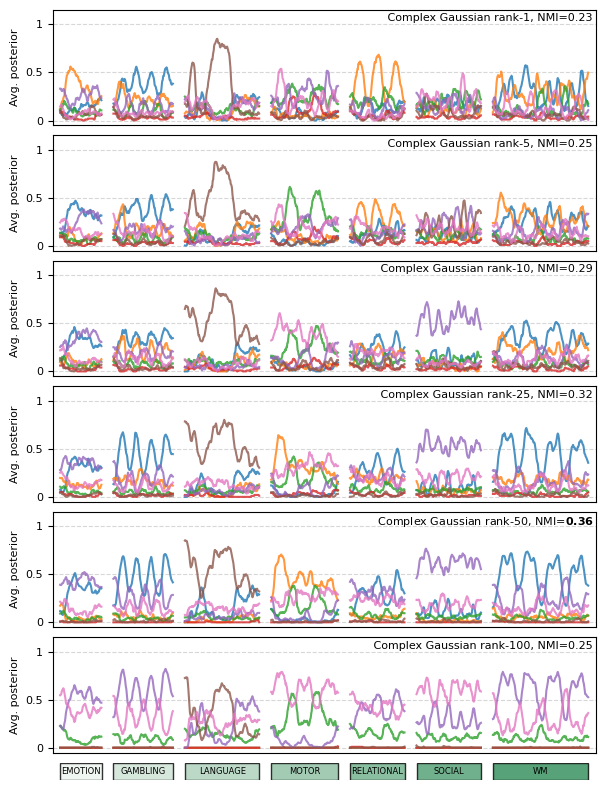

In [ ]:
# plot posteriors
modelname = 'Complex_Normal'
modelname2 = 'Mixture: Complex Gaussian'
inner = 0
ranks = [1,5,10,25,50,100]
tasks = ['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']
num_points = np.array([176,253,316,284,232,274,405])
K = len(tasks)
all_avg_test_posterior = []
for rank in ranks:
    print('Rank:', rank)
    posterior = np.genfromtxt('../data/results/116_results/posteriors/all_tasksmodelorder_realdata_'+modelname+'_K=7_rank='+str(rank)+'_inner'+str(inner)+'.txt', delimiter=',')
    avg_test_posterior = np.zeros((K,np.sum(num_points)))
    for sub in range(99):
        avg_test_posterior += 1/99*posterior[:,sub*np.sum(num_points):(sub+1)*np.sum(num_points)]
    all_avg_test_posterior.append(avg_test_posterior)
NMIs = []
for r in ranks:
    NMIs.append(df2_all_tasks[(df2_all_tasks['modelname'] == modelname2) & (df2_all_tasks['inner'] == inner) & (df2_all_tasks['Set'] == 'Out-of-sample test')& (df2_all_tasks['rank'] == r)]['NMI'].values.mean())

fig,axs = plot_posterior(all_avg_test_posterior, NMIs, ranks, modelname2[8:], highlight_rank=50)
fig.savefig('figures/complex_normal_posteriors_all_tasks.pdf', bbox_inches='tight')

In [11]:
#model order loglik data
df2_all_tasks_noGSR = pd.DataFrame()
ranks = [1,5,10,25,50,100]
modelnames = ['Complex_Watson','Normal','MACG','SingularWishart','Watson','ACG','least_squares','diametrical','complex_diametrical','grassmann','weighted_grassmann','Complex_ACG','Complex_Normal']
for modelname in modelnames:
    for rank in ranks:
        if modelname in ['Complex_Watson','Watson','least_squares','diametrical','complex_diametrical','grassmann','weighted_grassmann'] and rank != 25:
            continue
        try:
            df = pd.read_csv('../data/results/116_results/all_tasksmodelorder_realdata_'+modelname+'_K=7_rank='+str(rank)+'_noGSR.csv')
        except:
            print('File not found for model:', modelname, 'rank:', rank)
            continue
        df2_all_tasks_noGSR = pd.concat([df2_all_tasks_noGSR,df])
df2_all_tasks_noGSR = rename(df2_all_tasks_noGSR)

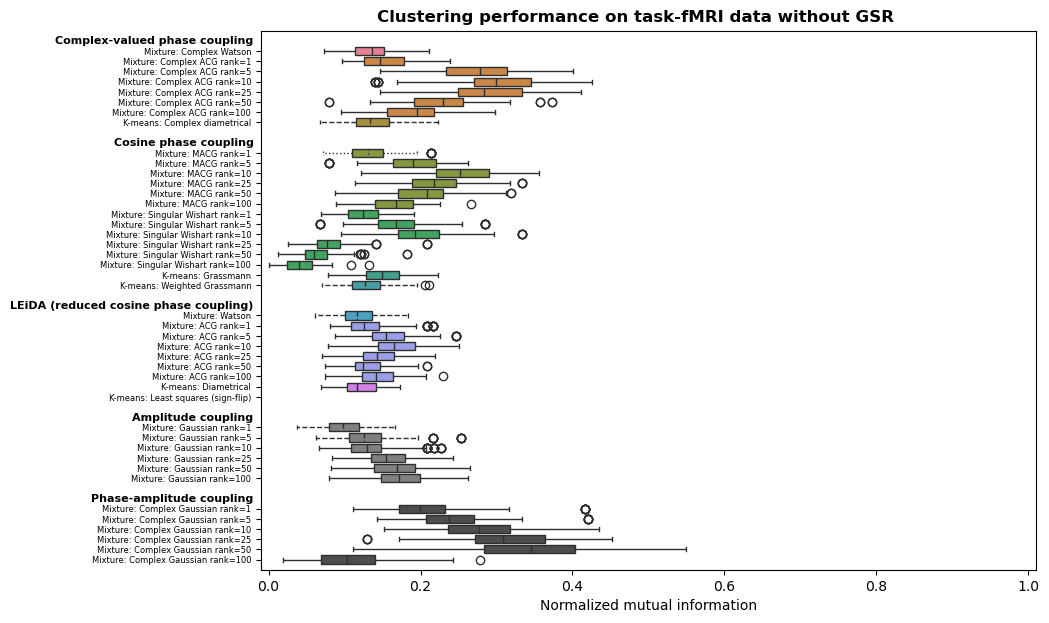

In [ ]:
df_fig = df2_all_tasks_noGSR[df2_all_tasks_noGSR['Set']=='Out-of-sample test']
df_fig = df_fig[df_fig['inner']==0]
fig = horizontal_boxplot(df_fig,type=1,ranks=ranks)
fig.suptitle('Clustering performance on task-fMRI data without GSR',fontsize=12, fontweight='bold', y=0.91)
fig.savefig('figures/alltasks_noGSR.pdf', bbox_inches='tight')

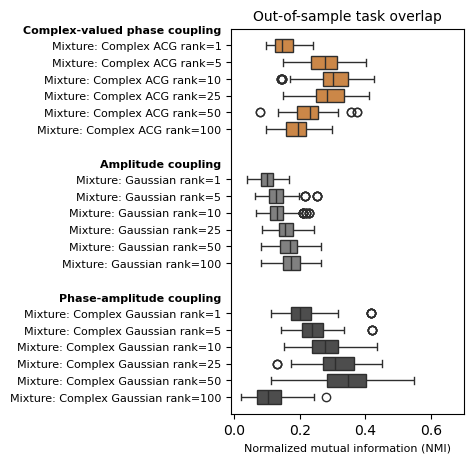

In [ ]:
ranks = [1,5,10,25,50,100]
order = [*['Mixture: Complex ACG rank='+str(rank) for rank in ranks],
    'space1','space2',
    *['Mixture: Gaussian rank='+str(rank) for rank in ranks],'space7','space8',
    *['Mixture: Complex Gaussian rank='+str(rank) for rank in ranks]]
palette_husl = sns.color_palette("husl", n_colors=11, desat=1)
palette_husl.append((0.5,0.5,0.5))
palette_husl.append((0.3,0.3,0.3))
palette_husl2 = [palette_husl[1]]*len(ranks)+[palette_husl[-1]]*2+[palette_husl[11]]*len(ranks)+[palette_husl[-1]]*2+[palette_husl[12]]*len(ranks)

for i in range(1,9):
    df_fig2 = pd.concat([df_fig,pd.DataFrame({'NMI':[np.nan],'names2':['space'+str(i)]}, index=[0])], ignore_index=True)
fig = plt.figure(figsize=(3,5))

sns.boxplot(x='NMI', y='names2', data=df_fig2, palette=palette_husl2, order=order)
plt.xlabel('Normalized mutual information (NMI)',fontsize=8)
plt.xlim([-0.01,1.01])
plt.ylabel('')

# add extra text next to y-ticks that aren't there
ticks_per_group = np.array([len(ranks), len(ranks), len(ranks)])
additional_ticks = np.concatenate([[0],np.cumsum(ticks_per_group+2)])
ticks_list = [np.arange(ticks_per_group[i]) + additional_ticks[i] for i in range(len(ticks_per_group))]
ticks_list = np.concatenate(ticks_list)

xtitlepos = -0.04
ytitlepos = [-0.7,7.3,15.3]
plt.yticks(ticks_list, fontsize=8)
    
plt.text(xtitlepos, ytitlepos[0], 'Complex-valued phase coupling', fontsize=8,fontweight='bold', ha='right')
plt.text(xtitlepos, ytitlepos[1], 'Amplitude coupling', fontsize=8,fontweight='bold', ha='right')
plt.text(xtitlepos, ytitlepos[2], 'Phase-amplitude coupling', fontsize=8,fontweight='bold', ha='right')

# change the line styles
styles = ['-']*len(ranks)+['-']*len(ranks)+['-']*len(ranks)
#repeat every element of styles six times
styles2 = [item for item in styles for i in range(5)]
l = 0
for i,artist in enumerate(plt.gca().get_children()):
    if isinstance(artist, plt.Line2D):
        #if linestyle is not none
        if artist.get_linestyle() != 'None':
            artist.set_linestyle(styles2[l])
            l+=1

plt.ylim([22,-1])
plt.xlim([-0.01,0.7])
plt.title('Out-of-sample task overlap', fontsize=10)
plt.savefig('figures/alltasks_nmi_3models_noGSR.pdf', bbox_inches='tight')

In [ ]:
modelnames = ['Complex_ACG','Normal','Complex_Normal']
from scipy.optimize import linear_sum_assignment
ranks_classification = [25,100,50]
num_points = np.array([176,253,316,284,232,274,405])  # number of points in each task
cumsum_num_points = np.concatenate([np.zeros(1),np.cumsum(num_points)]).astype(int)  # cumulative sum of number of points
K = len(num_points)  # number of tasks
true_labels = np.zeros(np.sum(num_points), dtype=int)
for i, task in enumerate(tasks):
    start = np.sum(num_points[:i])
    end = start + num_points[i]
    true_labels[start:end] = i  # Assign the task index to the corresponding range
# true_labels
accs = np.zeros((len(modelnames),99))
accs_ensemble = np.zeros((len(modelnames),99))
for i,modelname in enumerate(modelnames):
    # load posterior
    posterior_train = np.genfromtxt('../data/results/116_results/posteriors/all_tasksmodelorder_realdata_'+modelname+'_K=7_rank='+str(ranks_classification[i])+'_inner0_train.txt', delimiter=',')
    posterior_test = np.genfromtxt('../data/results/116_results/posteriors/all_tasksmodelorder_realdata_'+modelname+'_K=7_rank='+str(ranks_classification[i])+'_inner0_test.txt', delimiter=',')
    
    avg_train_posterior = np.zeros((K,np.sum(num_points)))
    for sub in range(155):
        avg_train_posterior += 1/155*posterior_train[:,sub*np.sum(num_points):(sub+1)*np.sum(num_points)]
    # order the components according to the NMI
    norm_avg_train_posterior = avg_train_posterior / np.sum(avg_train_posterior, axis=0, keepdims=True)
    bin_norm_avg_train_posterior = np.argmax(norm_avg_train_posterior, axis=0)  # binarize the posterior
    # calculate NMI
    avg_accs = np.zeros((K,K))
    for k1 in range(K): #task
        for k2 in range(K): #component
            # accs[k1,k2] = np.sum(true_labels[k1]==bin_norm_avg_test_posterior[k2])/ np.sum(true_labels[k1])
            avg_accs[k1,k2] = np.sum((true_labels==k1) & (bin_norm_avg_train_posterior==k2)) / np.sum(true_labels==k1)
    _,order = linear_sum_assignment(-avg_accs)

    for sub in range(99):
        test_posterior_sub = posterior_test[order,sub*np.sum(num_points):(sub+1)*np.sum(num_points)]
        tmp = np.argmax(test_posterior_sub, axis=0)  # binarize the posterior
        accs[i,sub] = np.sum(true_labels==tmp) / np.sum(num_points)
        # calculate the ensemble accuracy
        for scan in range(7):
            tmp2 = test_posterior_sub[:,cumsum_num_points[scan]:cumsum_num_points[scan+1]].mean(axis=1)
            most_often_occurring_label = np.argmax(tmp2)
            accs_ensemble[i,sub] += (most_often_occurring_label == scan)/7

In [15]:
names_3models = ['Complex-valued phase coupling\n(Complex ACG, r=25)','Amplitude coupling\n(Gaussian, r=100)','Phase-amplitude coupling\n(Complex Gaussian, r=50)']*99

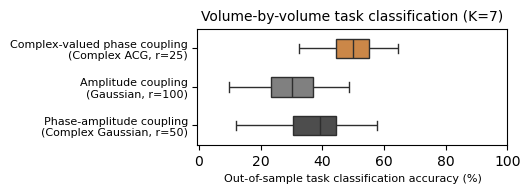

In [ ]:
plt.figure(figsize=(4,1.5))
palette_husl = sns.color_palette("husl", n_colors=11, desat=1)
palette_reduced = [palette_husl[1],(0.5,0.5,0.5),(0.3,0.3,0.3)]
df_accs = pd.DataFrame(data=100*np.hstack([accs[0],accs[1],accs[2]]),index=np.arange(1,298),columns=['Out-of-sample task classification accuracy (%)'])
df_accs['Model'] = [names_3models[0]]*99 + [names_3models[1]]*99 + [names_3models[2]]*99
sns.boxplot(x='Out-of-sample task classification accuracy (%)',y='Model',data=df_accs,palette=palette_reduced, dodge=False, width=0.5);
plt.xlim(-0.5,100)
plt.ylabel('')
# set yticklabels fontsize
plt.yticks(fontsize=8)
plt.xlabel('Out-of-sample task classification accuracy (%)', fontsize=8)
plt.title('Volume-by-volume task classification (K=7)', fontsize=10)
plt.savefig('figures/alltasks_classification_acc.pdf', bbox_inches='tight')

In [17]:
print(df_accs[df_accs['Model']==names_3models[0]]['Out-of-sample task classification accuracy (%)'].mean())
print(df_accs[df_accs['Model']==names_3models[1]]['Out-of-sample task classification accuracy (%)'].mean())
print(df_accs[df_accs['Model']==names_3models[2]]['Out-of-sample task classification accuracy (%)'].mean())

49.729771946266794
29.81828595230657
37.744454857856915


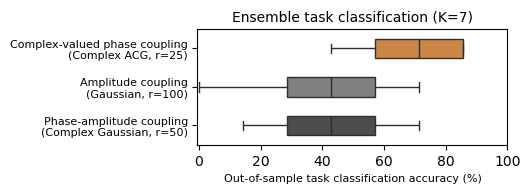

In [ ]:
plt.figure(figsize=(4,1.5))
palette_husl = sns.color_palette("husl", n_colors=11, desat=1)
palette_reduced = [palette_husl[1],(0.5,0.5,0.5),(0.3,0.3,0.3)]
df_accs_ensemble = pd.DataFrame(data=100*np.hstack([accs_ensemble[0],accs_ensemble[1],accs_ensemble[2]]),index=np.arange(1,298),columns=['Out-of-sample task classification accuracy (%)'])
df_accs_ensemble['Model'] = [names_3models[0]]*99 + [names_3models[1]]*99 + [names_3models[2]]*99
sns.boxplot(x='Out-of-sample task classification accuracy (%)',y='Model',data=df_accs_ensemble,palette=palette_reduced, dodge=False, width=0.5);
plt.xlim(-0.5,100)
plt.ylabel('')
plt.yticks(fontsize=8)
plt.xlabel('Out-of-sample task classification accuracy (%)', fontsize=8)
plt.title('Ensemble task classification (K=7)', fontsize=10)
plt.savefig('figures/alltasks_classification_ensemble_acc.pdf', bbox_inches='tight')

In [19]:
print(df_accs_ensemble[df_accs_ensemble['Model']==names_3models[0]]['Out-of-sample task classification accuracy (%)'].mean())
print(df_accs_ensemble[df_accs_ensemble['Model']==names_3models[1]]['Out-of-sample task classification accuracy (%)'].mean())
print(df_accs_ensemble[df_accs_ensemble['Model']==names_3models[2]]['Out-of-sample task classification accuracy (%)'].mean())

71.86147186147184
36.94083694083693
41.414141414141405


In [ ]:
modelnames = ['Complex_ACG','Normal','Complex_Normal']
from scipy.optimize import linear_sum_assignment
ranks_classification = [25,100,50]
num_points = np.array([176,253,316,284,232,274,405])  # number of points in each task
cumsum_num_points = np.concatenate([np.zeros(1),np.cumsum(num_points)]).astype(int)  # cumulative sum of number of points
K = len(num_points)  # number of tasks
true_labels = np.zeros(np.sum(num_points), dtype=int)
for i, task in enumerate(tasks):
    start = np.sum(num_points[:i])
    end = start + num_points[i]
    true_labels[start:end] = i  # Assign the task index to the corresponding range
# true_labels
accs = np.zeros((len(modelnames),99))
accs_ensemble = np.zeros((len(modelnames),99))
for i,modelname in enumerate(modelnames):
    # load posterior
    posterior_train = np.genfromtxt('../data/results/116_results/posteriors/all_tasksmodelorder_realdata_'+modelname+'_K=7_rank='+str(ranks_classification[i])+'_noGSR_inner0_train.txt', delimiter=',')
    posterior_test = np.genfromtxt('../data/results/116_results/posteriors/all_tasksmodelorder_realdata_'+modelname+'_K=7_rank='+str(ranks_classification[i])+'_noGSR_inner0_test.txt', delimiter=',')
    
    avg_train_posterior = np.zeros((K,np.sum(num_points)))
    for sub in range(155):
        avg_train_posterior += 1/155*posterior_train[:,sub*np.sum(num_points):(sub+1)*np.sum(num_points)]
    # order the components according to the NMI
    norm_avg_train_posterior = avg_train_posterior / np.sum(avg_train_posterior, axis=0, keepdims=True)
    bin_norm_avg_train_posterior = np.argmax(norm_avg_train_posterior, axis=0)  # binarize the posterior
    # calculate NMI
    avg_accs = np.zeros((K,K))
    for k1 in range(K): #task
        for k2 in range(K): #component
            # accs[k1,k2] = np.sum(true_labels[k1]==bin_norm_avg_test_posterior[k2])/ np.sum(true_labels[k1])
            avg_accs[k1,k2] = np.sum((true_labels==k1) & (bin_norm_avg_train_posterior==k2)) / np.sum(true_labels==k1)
    _,order = linear_sum_assignment(-avg_accs)

    for sub in range(99):
        test_posterior_sub = posterior_test[order,sub*np.sum(num_points):(sub+1)*np.sum(num_points)]
        tmp = np.argmax(test_posterior_sub, axis=0)  # binarize the posterior
        accs[i,sub] = np.sum(true_labels==tmp) / np.sum(num_points)
        # calculate the ensemble accuracy
        for scan in range(7):
            tmp2 = test_posterior_sub[:,cumsum_num_points[scan]:cumsum_num_points[scan+1]].mean(axis=1)
            most_often_occurring_label = np.argmax(tmp2)
            accs_ensemble[i,sub] += (most_often_occurring_label == scan)/7

/tmp/ipykernel_3460521/1404400325.py:7: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(x='Out-of-sample task classification accuracy (%)',y='Model',data=df_accs,palette=palette_reduced, dodge=False, width=0.5);


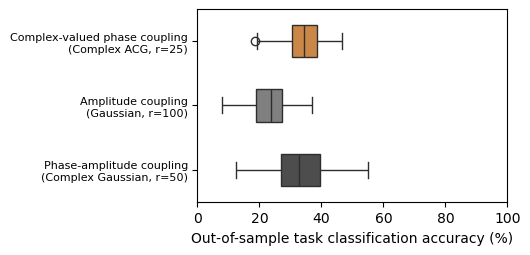

In [ ]:
plt.figure(figsize=(4,2.5))
palette_husl = sns.color_palette("husl", n_colors=11, desat=1)
palette_reduced = [palette_husl[1],(0.5,0.5,0.5),(0.3,0.3,0.3),(0,0,0)]
df_accs = pd.DataFrame(data=100*np.hstack([accs[0],accs[1],accs[2]]),index=np.arange(1,298),columns=['Out-of-sample task classification accuracy (%)'])
df_accs['Model'] = [names_3models[0]]*99 + [names_3models[1]]*99 + [names_3models[2]]*99
sns.boxplot(x='Out-of-sample task classification accuracy (%)',y='Model',data=df_accs,palette=palette_reduced, dodge=False, width=0.5);
plt.xlim(0,100)
plt.ylabel('')
plt.yticks(fontsize=8)
plt.savefig('figures/alltasks_classification_acc_noGSR.pdf', bbox_inches='tight')

In [22]:
print(df_accs[df_accs['Model']==names_3models[0]]['Out-of-sample task classification accuracy (%)'].mean())
print(df_accs[df_accs['Model']==names_3models[1]]['Out-of-sample task classification accuracy (%)'].mean())
print(df_accs[df_accs['Model']==names_3models[2]]['Out-of-sample task classification accuracy (%)'].mean())

34.20701864000833
23.33020930959075
32.94283036551077
